#Ch07_펩타이드 최적화 - 경구용 펩타이드

SEIHWAN 2025


# 0. 필요한 라이브러리 설치 및 불러 오기

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Oral Peptide Sequence Generation Model (Simplified Version)
"""

# 필요한 라이브러리 설치
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    !pip install tensorflow -q
    import tensorflow as tf
    print(f"TensorFlow installed, version: {tf.__version__}")

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import os
from tqdm.notebook import tqdm

# 한글 폰트 설정 관련 코드 제거 (영어만 사용)
# 랜덤 시드 설정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

TensorFlow version: 2.18.0


# 1. 샘플 데이터 생성 (실제 데이터가 있을 시 대체하세요)

In [ ]:
#############################################################
# 1. 샘플 데이터 생성
#############################################################

print("=== Peptide Data Generation ===")

def generate_sample_data(n_samples=1000):
    """
    Generate sample peptide data
    """
    # Standard 20 amino acids
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    sequences = []
    oral_bioavailability = []

    # Generate random peptides
    for _ in range(n_samples):
        length = random.randint(5, 15)
        seq = ''.join(random.choices(amino_acids, k=length))
        sequences.append(seq)

        # Simple rule-based oral bioavailability prediction
        hydrophobic = sum(seq.count(aa) for aa in ['A', 'F', 'I', 'L', 'M', 'V', 'W'])
        if hydrophobic / len(seq) >= 0.4 and 'C' in seq and len(seq) < 12:
            oral_bioavailability.append(1)  # Has oral bioavailability
        else:
            oral_bioavailability.append(0)  # No oral bioavailability

    data = pd.DataFrame({
        'sequence': sequences,
        'oral_bioavailability': oral_bioavailability
    })

    return data

# Generate data
peptide_data = generate_sample_data(1500)
print(f"Generated data: {peptide_data.shape[0]} sequences")
print(peptide_data.head())

# Check oral bioavailability distribution
print(f"Oral bioavailability distribution: {peptide_data['oral_bioavailability'].value_counts().to_dict()}")

=== Peptide Data Generation ===
Generated data: 1500 sequences
          sequence  oral_bioavailability
0  DRFDDRMNACFPNRR                     0
1      FNTATQHEYHC                     0
2           IHGALD                     0
3      CGPVIECQSYV                     0
4           ILTEIQ                     0
Oral bioavailability distribution: {0: 1393, 1: 107}


# 2. 데이터 전처리

In [ ]:
#############################################################
# 2. 데이터 전처리
#############################################################

print("\n=== Data Preprocessing ===")

# Character-level tokenization
def tokenize_sequences(sequences):
    """Tokenize sequences at character level"""
    # Collect all unique characters
    chars = set()
    for seq in sequences:
        chars.update(seq)

    # Create sorted list of characters
    char_list = sorted(list(chars))

    # Add special tokens (after sorted characters)
    special_tokens = ['<PAD>', '<START>', '<END>']

    # Create character-index mappings
    char_to_idx = {c: i for i, c in enumerate(char_list + special_tokens)}
    idx_to_char = {i: c for c, i in char_to_idx.items()}

    return char_to_idx, idx_to_char

# Sequence encoding
def encode_sequences(sequences, char_to_idx):
    """Convert sequences to index lists"""
    start_idx = char_to_idx['<START>']
    end_idx = char_to_idx['<END>']

    encoded = []
    for seq in sequences:
        # Convert each character to index
        seq_indices = [char_to_idx[c] for c in seq]
        # Add start/end tokens
        seq_indices = [start_idx] + seq_indices + [end_idx]
        encoded.append(seq_indices)

    return encoded

# 학습 데이터 생성
def create_n_gram_data(encoded_sequences, n=3):
    """N-gram 형식의 학습 데이터 생성"""
    X, y = [], []
    for seq in encoded_sequences:
        # 시퀀스가 충분히 길지 않으면 스킵
        if len(seq) < n + 1:
            continue

        # n-gram 생성
        for i in range(len(seq) - n):
            X.append(seq[i:i+n])
            y.append(seq[i+n])

    return np.array(X), np.array(y)

# 경구 활성 있는 시퀀스만 선택
oral_sequences = peptide_data[peptide_data['oral_bioavailability'] == 1]['sequence'].values

if len(oral_sequences) < 10:
    print("경구 활성 있는 시퀀스가 너무 적어 모든 시퀀스를 사용합니다.")
    oral_sequences = peptide_data['sequence'].values

print(f"학습에 사용될 시퀀스: {len(oral_sequences)}개")

# 토큰화
char_to_idx, idx_to_char = tokenize_sequences(oral_sequences)
print(f"고유 문자 수: {len(char_to_idx)}")

# 인코딩
encoded_sequences = encode_sequences(oral_sequences, char_to_idx)

# N-gram 데이터 생성 (3-gram 사용)
X, y = create_n_gram_data(encoded_sequences, n=3)
print(f"생성된 학습 데이터: {X.shape}, {y.shape}")

# Check data size
if len(X) < 10:
    print("Warning: Too little data generated. Adding more sample data.")
    # Generate more sample data
    additional_data = generate_sample_data(1000)
    additional_sequences = additional_data['sequence'].values

    # Tokenize and encode with existing char_to_idx
    encoded_additional = []
    start_idx = char_to_idx['<START>']
    end_idx = char_to_idx['<END>']

    for seq in additional_sequences:
        valid_chars = [c for c in seq if c in char_to_idx]
        if valid_chars:
            encoded_additional.append([start_idx] + [char_to_idx[c] for c in valid_chars] + [end_idx])

    # Create additional n-gram data
    X_add, y_add = create_n_gram_data(encoded_additional, n=3)

    # Merge with existing data
    if len(X_add) > 0:
        X = np.concatenate([X, X_add]) if len(X) > 0 else X_add
        y = np.concatenate([y, y_add]) if len(y) > 0 else y_add
        print(f"Data size after augmentation: {X.shape}, {y.shape}")

# Split into train/validation sets
if len(X) > 0:
    train_ratio = 0.8
    split_idx = int(len(X) * train_ratio)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    print(f"Training data: {X_train.shape}, {y_train.shape}")
    print(f"Validation data: {X_val.shape}, {y_val.shape}")
else:
    print("Error: Could not generate training data.")
    # Create dummy data for continued execution
    vocab_size = len(char_to_idx)
    X_train = np.zeros((10, 3), dtype=np.int32)
    y_train = np.zeros(10, dtype=np.int32)
    X_val = np.zeros((2, 3), dtype=np.int32)
    y_val = np.zeros(2, dtype=np.int32)


=== Data Preprocessing ===
학습에 사용될 시퀀스: 107개
고유 문자 수: 23
생성된 학습 데이터: (771, 3), (771,)
Training data: (616, 3), (616,)
Validation data: (155, 3), (155,)


# 3. 모델 구축 및 학습


=== Model Building and Training ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0518 - loss: 3.1322 - val_accuracy: 0.1484 - val_loss: 3.1073
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1792 - loss: 3.0737 - val_accuracy: 0.1806 - val_loss: 3.0610
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1909 - loss: 3.0014 - val_accuracy: 0.1548 - val_loss: 2.9855
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1602 - loss: 2.8991 - val_accuracy: 0.1484 - val_loss: 2.9183
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1526 - loss: 2.8114 - val_accuracy: 0.1613 - val_loss: 2.8995
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1753 - loss: 2.7468 - val_accuracy: 0.1548 - val_loss: 2.8941
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2035 - loss: 2.6731 - val_accuracy: 0.1613 - val_loss: 2.8981
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2024 - loss: 2.6350 - val_accuracy: 0.1677 - val_lo

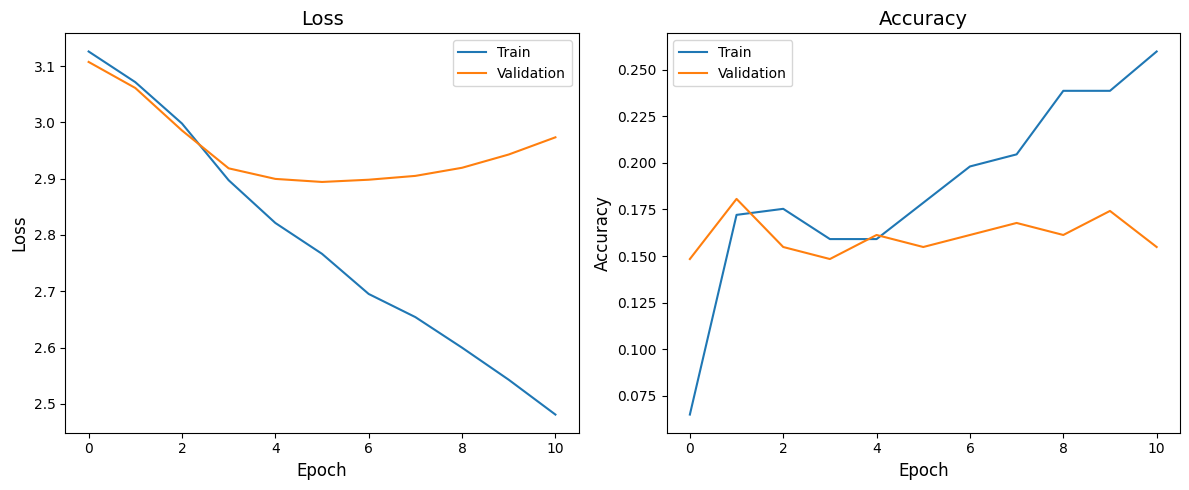


[학습 곡선 분석]
왼쪽 그래프는 손실(Loss) 값의 변화를 보여줍니다. 학습이 진행됨에 따라 손실이 감소하는 것이 이상적이며, 검증 손실이 증가하기 시작하면 과적합의 징후입니다.

오른쪽 그래프는 정확도(Accuracy)의 변화를 보여줍니다. 학습 정확도와 검증 정확도가 함께 상승하는 것이 좋은 학습 과정을 나타냅니다. 두 값의 간격이 크게 벌어지면 과적합이 발생했음을 의미합니다.



In [ ]:
#############################################################
# 3. 모델 구축 및 학습
#############################################################

print("\n=== Model Building and Training ===")

# Convert to one-hot encoding
def to_categorical(y, num_classes):
    """Convert to one-hot encoding"""
    return np.eye(num_classes)[y]

# Convert to one-hot encoding
y_train_onehot = to_categorical(y_train, len(char_to_idx))
y_val_onehot = to_categorical(y_val, len(char_to_idx))

# Build a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(char_to_idx), 64, input_length=3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(char_to_idx), activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model
epochs = 20
history = model.fit(
    X_train, y_train_onehot,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_val, y_val_onehot),
    callbacks=[early_stopping],
    verbose=1
)

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

print("""
[학습 곡선 분석]
왼쪽 그래프는 손실(Loss) 값의 변화를 보여줍니다. 학습이 진행됨에 따라 손실이 감소하는 것이 이상적이며, 검증 손실이 증가하기 시작하면 과적합의 징후입니다.

오른쪽 그래프는 정확도(Accuracy)의 변화를 보여줍니다. 학습 정확도와 검증 정확도가 함께 상승하는 것이 좋은 학습 과정을 나타냅니다. 두 값의 간격이 크게 벌어지면 과적합이 발생했음을 의미합니다.
""")

In [ ]:
# 모델 정의 후
model(X_train[:1])  # 샘플 데이터 한 개 전달
model.summary()     # 이제 파라미터와 출력 형태가 표시됨

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 3, 64)               │           1,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 23)                  │           2,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,431 (341.53 KB)

 Trainable params: 29,143 (113.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,288 (227.69 KB)

# 4. 새로운 펩타이드 생성

In [ ]:
import numpy as np
import pandas as pd
import random

# 아미노산 물성 정의
aa_properties = {
    'A': {'hydrophobicity': 1.8, 'weight': 89.09, 'charge': 0},
    'C': {'hydrophobicity': 2.5, 'weight': 121.16, 'charge': 0},
    'D': {'hydrophobicity': -3.5, 'weight': 133.10, 'charge': -1},
    'E': {'hydrophobicity': -3.5, 'weight': 147.13, 'charge': -1},
    'F': {'hydrophobicity': 2.8, 'weight': 165.19, 'charge': 0},
    'G': {'hydrophobicity': -0.4, 'weight': 75.07, 'charge': 0},
    'H': {'hydrophobicity': -3.2, 'weight': 155.16, 'charge': 0.5},
    'I': {'hydrophobicity': 4.5, 'weight': 131.17, 'charge': 0},
    'K': {'hydrophobicity': -3.9, 'weight': 146.19, 'charge': 1},
    'L': {'hydrophobicity': 3.8, 'weight': 131.17, 'charge': 0},
    'M': {'hydrophobicity': 1.9, 'weight': 149.21, 'charge': 0},
    'N': {'hydrophobicity': -3.5, 'weight': 132.12, 'charge': 0},
    'P': {'hydrophobicity': -1.6, 'weight': 115.13, 'charge': 0},
    'Q': {'hydrophobicity': -3.5, 'weight': 146.15, 'charge': 0},
    'R': {'hydrophobicity': -4.5, 'weight': 174.20, 'charge': 1},
    'S': {'hydrophobicity': -0.8, 'weight': 105.09, 'charge': 0},
    'T': {'hydrophobicity': -0.7, 'weight': 119.12, 'charge': 0},
    'V': {'hydrophobicity': 4.2, 'weight': 117.15, 'charge': 0},
    'W': {'hydrophobicity': -0.9, 'weight': 204.23, 'charge': 0},
    'Y': {'hydrophobicity': -1.3, 'weight': 181.19, 'charge': 0}
}

# 소수성 아미노산 목록
hydrophobic_aas = ['A', 'F', 'I', 'L', 'M', 'V', 'W']

# 경구용 펩타이드에 유리한 아미노산 가중치 설정
oral_weights = {
    'A': 2.0,  # 소수성, 작은 크기
    'C': 3.0,  # 시스테인 (경구 활성에 중요)
    'F': 1.5,  # 소수성
    'I': 1.5,  # 소수성
    'L': 1.5,  # 소수성
    'M': 1.5,  # 소수성
    'V': 1.5,  # 소수성
    'W': 1.0,  # 소수성이지만 크기가 큼
    'G': 1.2,  # 작은 크기
    'P': 1.2,  # 구조 안정성
    'S': 1.0,
    'T': 1.0,
    'Y': 0.8,
    'H': 0.5,
    'K': 0.5,
    'R': 0.5,
    'D': 0.5,
    'E': 0.5,
    'N': 0.5,
    'Q': 0.5
}

def generate_random_peptide(min_length=5, max_length=10, oral_biased=True):
    """경구용 활성 가능성이 높은 펩타이드 생성"""
    # 펩타이드 길이 결정
    length = random.randint(min_length, max_length)

    # 아미노산 목록
    all_aas = list(aa_properties.keys())

    # 경구용 활성 편향 적용
    if oral_biased:
        # 가중치 기반 아미노산 선택
        weights = [oral_weights.get(aa, 1.0) for aa in all_aas]
        peptide_aas = random.choices(all_aas, weights=weights, k=length)

        # 시스테인 포함 확률 증가 (경구 활성에 중요)
        if 'C' not in peptide_aas and random.random() < 0.6:
            position = random.randint(0, length-1)
            peptide_aas[position] = 'C'
    else:
        # 균등 확률 선택
        peptide_aas = random.choices(all_aas, k=length)

    return ''.join(peptide_aas)

def calculate_properties(peptide):
    """펩타이드 물성 계산"""
    # 물성 계산
    props = {}

    # 분자량
    props['molecular_weight'] = sum(aa_properties.get(aa, {'weight': 0})['weight'] for aa in peptide)

    # 소수성
    hydrophobicity = [aa_properties.get(aa, {'hydrophobicity': 0})['hydrophobicity'] for aa in peptide]
    props['hydrophobicity'] = sum(hydrophobicity) / len(peptide) if peptide else 0

    # 순 전하
    props['net_charge'] = sum(aa_properties.get(aa, {'charge': 0})['charge'] for aa in peptide)

    # 소수성 아미노산 비율
    props['hydrophobic_ratio'] = sum(peptide.count(aa) for aa in hydrophobic_aas) / len(peptide) if peptide else 0

    # 시스테인 수
    props['cys_count'] = peptide.count('C')

    # 경구 활성 예측 (규칙 기반)
    if (props['hydrophobic_ratio'] >= 0.4 and props['cys_count'] > 0 and len(peptide) < 12):
        props['predicted_oral'] = 1
    else:
        props['predicted_oral'] = 0

    return props

def generate_peptide_dataset(n_peptides=50, oral_ratio=0.7, filename='generated_peptides.csv'):
    """경구 활성 비율을 조절하여 펩타이드 데이터셋 생성"""
    peptides = []
    oral_count = 0
    total_count = 0

    print("펩타이드 생성 중...")

    # 목표 개수에 도달할 때까지 생성
    while total_count < n_peptides:
        # 경구 편향도 결정 (목표 비율에 따라 조절)
        if oral_count < oral_ratio * n_peptides:
            oral_biased = True
        else:
            oral_biased = random.random() < 0.3  # 30% 확률로 경구 편향 유지

        # 펩타이드 생성
        peptide = generate_random_peptide(oral_biased=oral_biased)
        props = calculate_properties(peptide)

        # 경구 활성 갯수 계산
        if props['predicted_oral'] == 1:
            oral_count += 1

        # 데이터 추가
        props['sequence'] = peptide
        props['temperature'] = round(random.uniform(0.7, 1.2), 1)  # 임의의 온도값 추가
        peptides.append(props)
        total_count += 1

        # 진행 상황 출력
        if total_count % 10 == 0:
            print(f"  {total_count}/{n_peptides} 완료 (경구 활성: {oral_count}개)")

    # DataFrame 생성 및 저장
    df = pd.DataFrame(peptides)
    df.to_csv(filename, index=False)

    print(f"{n_peptides}개 펩타이드가 생성되었습니다 (경구 활성: {oral_count}개, {oral_count/n_peptides*100:.1f}%)")
    print(f"데이터가 {filename}에 저장되었습니다.")

    return df

# 메인 실행 코드
n_peptides = 100  # 생성할 펩타이드 수
oral_ratio = 0.7  # 경구 활성 비율 목표 (0.0~1.0)
output_file = 'generated_peptides.csv'  # 저장 파일명

# 펩타이드 생성 및 저장 실행
generate_peptide_dataset(n_peptides=n_peptides, oral_ratio=oral_ratio, filename=output_file)

펩타이드 생성 중...
  10/100 완료 (경구 활성: 4개)
  20/100 완료 (경구 활성: 7개)
  30/100 완료 (경구 활성: 16개)
  40/100 완료 (경구 활성: 22개)
  50/100 완료 (경구 활성: 25개)
  60/100 완료 (경구 활성: 33개)
  70/100 완료 (경구 활성: 39개)
  80/100 완료 (경구 활성: 42개)
  90/100 완료 (경구 활성: 48개)
  100/100 완료 (경구 활성: 53개)
100개 펩타이드가 생성되었습니다 (경구 활성: 53개, 53.0%)
데이터가 generated_peptides.csv에 저장되었습니다.


,molecular_weight,hydrophobicity,net_charge,hydrophobic_ratio,cys_count,predicted_oral,sequence,temperature
0,1164.39,1.433333,0.0,0.555556,1,1,NVQSLIMLC,1.1
1,1363.55,0.230000,-1.0,0.300000,1,0,MFYIPTCTPE,0.8
2,688.84,1.600000,0.0,0.600000,1,1,VCLWP,1.2
3,1282.42,-0.266667,-1.0,0.222222,2,0,NMCDLCYYN,0.9
4,1121.37,1.562500,0.0,0.500000,3,1,WCVCCVWP,1.0
...,...,...,...,...,...,...,...,...
95,773.95,1.666667,0.0,0.333333,3,0,CCGLCW,0.8
96,784.91,0.083333,1.0,0.166667,2,0,CTNRCV,1.0
97,1002.06,-1.550000,0.0,0.125000,1,0,ETNPAKNC,1.0
98,1249.49,1.850000,0.5,0.600000,1,1,ALSVTCIIMH,0.9


# 5. 생성된 펩타이드 평가


=== Peptide Evaluation ===
Loaded 100 peptides from generated_peptides.csv
Using 'sequence' as the peptide sequence column

=== Peptide Properties ===
     sequence  temperature  molecular_weight  hydrophobicity  net_charge  \
0   NVQSLIMLC          1.1           1164.39        1.433333         0.0   
1  MFYIPTCTPE          0.8           1363.55        0.230000        -1.0   
2       VCLWP          1.2            688.84        1.600000         0.0   
3   NMCDLCYYN          0.9           1282.42       -0.266667        -1.0   
4    WCVCCVWP          1.0           1121.37        1.562500         0.0   

   predicted_oral  
0               1  
1               0  
2               1  
3               0  
4               1  

=== Property Statistics ===
       molecular_weight  hydrophobicity  net_charge  hydrophobic_ratio
count        100.000000      100.000000  100.000000         100.000000
mean        1002.395900        0.886096   -0.025000           0.493980
std          226.571003      

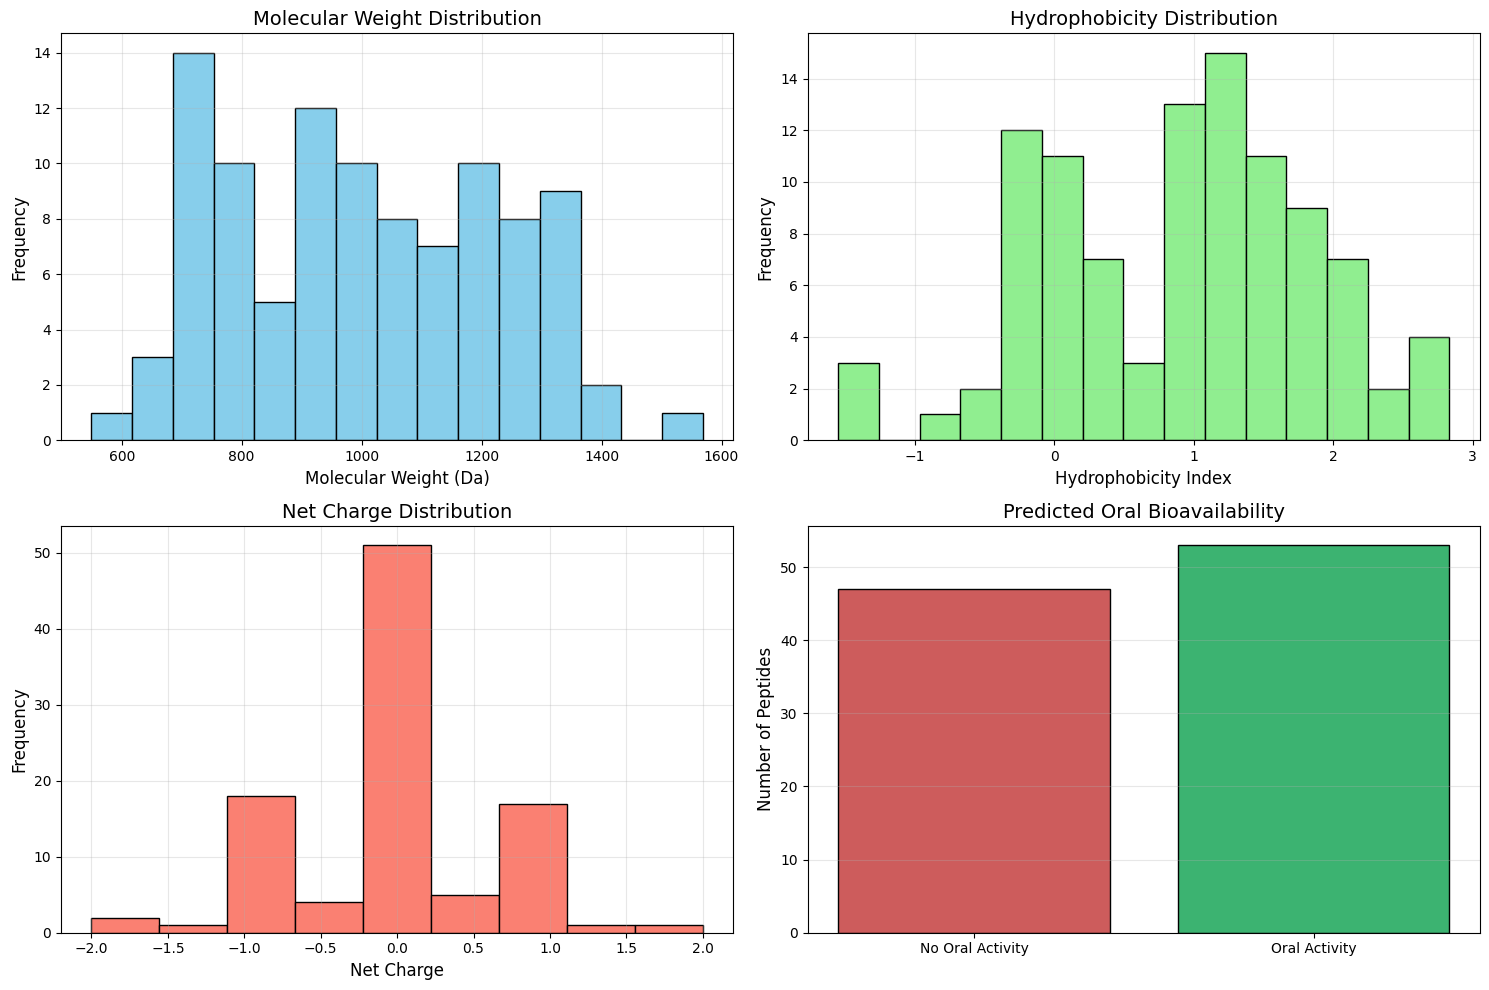


Results saved to 'evaluated_peptides.csv'

    [물성 분포 분석]
    1. 분자량 분포 (좌상단): 
       생성된 펩타이드의 분자량(Da) 분포를 보여줍니다. 경구 펩타이드는 일반적으로 분자량이 작을수록 흡수율이 높습니다. 
       500-700 Da 범위가 립린스키 규칙에 따른 경구 약물의 이상적인 범위입니다.
    
    2. 소수성 분포 (우상단): 
       펩타이드의 소수성 지수 분포입니다. 소수성이 높을수록 세포막 투과성이 증가하지만, 용해도는 감소합니다.
       경구 활성 펩타이드는 적절한 소수성-친수성 균형을 가져야 합니다.
    
    3. 순 전하 분포 (좌하단): 
       펩타이드의 순 전하 분포로, 생리학적 pH에서의 이온화 정도를 나타냅니다.
       강한 양전하나 음전하는 막 투과성을 낮추므로, 경구 활성 펩타이드는 중성에 가까운 전하가 유리합니다.
    
    4. 경구 활성 예측 (우하단): 
       규칙 기반으로 예측된 경구 활성 여부 분포입니다. 소수성 비율, 시스테인 존재 여부, 크기를 고려한 간단한 예측입니다.
       실제 경구 활성은 더 복잡한 요인들에 의해 결정됩니다.
    

=== Oral vs Non-Oral Peptide Comparison ===
                   Oral Peptides  Non-Oral Peptides
molecular_weight     1033.402453         967.431064
hydrophobicity          1.332120           0.383132
net_charge              0.028302          -0.085106
hydrophobic_ratio       0.570448           0.407751

Example Oral Peptides:
1. NVQSLIMLC (MW: 1164.4, Hydro: 1.43, Ch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#############################################################
# 5. 생성된 펩타이드 평가
#############################################################

print("\n=== Peptide Evaluation ===")

def calculate_properties(peptide):
    """Calculate peptide properties"""
    # Amino acid properties (hydrophobicity, molecular weight, charge)
    aa_properties = {
        'A': {'hydrophobicity': 1.8, 'weight': 89.09, 'charge': 0},
        'C': {'hydrophobicity': 2.5, 'weight': 121.16, 'charge': 0},
        'D': {'hydrophobicity': -3.5, 'weight': 133.10, 'charge': -1},
        'E': {'hydrophobicity': -3.5, 'weight': 147.13, 'charge': -1},
        'F': {'hydrophobicity': 2.8, 'weight': 165.19, 'charge': 0},
        'G': {'hydrophobicity': -0.4, 'weight': 75.07, 'charge': 0},
        'H': {'hydrophobicity': -3.2, 'weight': 155.16, 'charge': 0.5},
        'I': {'hydrophobicity': 4.5, 'weight': 131.17, 'charge': 0},
        'K': {'hydrophobicity': -3.9, 'weight': 146.19, 'charge': 1},
        'L': {'hydrophobicity': 3.8, 'weight': 131.17, 'charge': 0},
        'M': {'hydrophobicity': 1.9, 'weight': 149.21, 'charge': 0},
        'N': {'hydrophobicity': -3.5, 'weight': 132.12, 'charge': 0},
        'P': {'hydrophobicity': -1.6, 'weight': 115.13, 'charge': 0},
        'Q': {'hydrophobicity': -3.5, 'weight': 146.15, 'charge': 0},
        'R': {'hydrophobicity': -4.5, 'weight': 174.20, 'charge': 1},
        'S': {'hydrophobicity': -0.8, 'weight': 105.09, 'charge': 0},
        'T': {'hydrophobicity': -0.7, 'weight': 119.12, 'charge': 0},
        'V': {'hydrophobicity': 4.2, 'weight': 117.15, 'charge': 0},
        'W': {'hydrophobicity': -0.9, 'weight': 204.23, 'charge': 0},
        'Y': {'hydrophobicity': -1.3, 'weight': 181.19, 'charge': 0}
    }

    # Calculate properties
    props = {}

    # Molecular weight
    props['molecular_weight'] = sum(aa_properties.get(aa, {'weight': 0})['weight'] for aa in peptide)

    # Hydrophobicity
    hydrophobicity = [aa_properties.get(aa, {'hydrophobicity': 0})['hydrophobicity'] for aa in peptide]
    props['hydrophobicity'] = sum(hydrophobicity) / len(peptide) if peptide else 0

    # Net charge
    props['net_charge'] = sum(aa_properties.get(aa, {'charge': 0})['charge'] for aa in peptide)

    # Hydrophobic amino acid ratio
    hydrophobic_aas = ['A', 'F', 'I', 'L', 'M', 'V', 'W']
    props['hydrophobic_ratio'] = sum(peptide.count(aa) for aa in hydrophobic_aas) / len(peptide) if peptide else 0

    # Cys count (disulfide bond potential)
    props['cys_count'] = peptide.count('C')

    # Predicted oral bioavailability (simple rule-based)
    if (props['hydrophobic_ratio'] >= 0.4 and props['cys_count'] > 0 and len(peptide) < 12):
        props['predicted_oral'] = 1
    else:
        props['predicted_oral'] = 0

    return props

def evaluate_peptides_from_csv(csv_file='generated_peptides.csv'):
    """
    Load peptides from CSV file and evaluate their properties

    Args:
        csv_file: Path to CSV file containing peptides

    Returns:
        DataFrame with peptides and their calculated properties
    """
    try:
        # Load the CSV file
        peptides_df = pd.read_csv(csv_file)
        print(f"Loaded {len(peptides_df)} peptides from {csv_file}")

        # Check if the expected column exists
        if 'sequence' not in peptides_df.columns:
            # Try to find the column that contains peptide sequences
            if len(peptides_df.columns) > 0:
                # Assume the peptide sequence is in one of these possible columns
                for col in ['peptide', 'sequence', 'peptide_sequence']:
                    if col in peptides_df.columns:
                        sequence_column = col
                        break
                else:
                    # If no matching column is found, use the third column (index 2)
                    # This assumes a structure like: temperature, sample_number, sequence, length
                    sequence_column = peptides_df.columns[2] if len(peptides_df.columns) > 2 else peptides_df.columns[0]
            else:
                raise ValueError("CSV file has no columns")
        else:
            sequence_column = 'sequence'

        print(f"Using '{sequence_column}' as the peptide sequence column")

        # Calculate properties for each peptide
        all_peptides = []
        for idx, row in peptides_df.iterrows():
            peptide = row[sequence_column]

            # Skip if peptide is empty or not a string
            if not isinstance(peptide, str) or not peptide:
                continue

            # Calculate properties
            props = calculate_properties(peptide)

            # Add original data
            for col in peptides_df.columns:
                props[col] = row[col]

            all_peptides.append(props)

        # Convert to DataFrame
        results_df = pd.DataFrame(all_peptides)

        return results_df

    except Exception as e:
        print(f"Error evaluating peptides: {str(e)}")
        return pd.DataFrame()

# Load and evaluate peptides
results_df = evaluate_peptides_from_csv('generated_peptides.csv')

if not results_df.empty:
    print("\n=== Peptide Properties ===")
    display_cols = ['sequence', 'temperature', 'molecular_weight', 'hydrophobicity', 'net_charge', 'predicted_oral']
    print(results_df[display_cols].head())

    # Statistics
    print("\n=== Property Statistics ===")
    stats = results_df[['molecular_weight', 'hydrophobicity', 'net_charge', 'hydrophobic_ratio']].describe()
    print(stats)

    # Oral bioavailability
    oral_count = results_df['predicted_oral'].sum()
    oral_percent = (oral_count / len(results_df)) * 100
    print(f"\nPredicted oral bioavailability: {oral_count}/{len(results_df)} peptides ({oral_percent:.1f}%)")

    # Temperature effect analysis
    if 'temperature' in results_df.columns:
        print("\n=== Temperature Effect ===")
        temp_stats = results_df.groupby('temperature')[['hydrophobicity', 'molecular_weight', 'predicted_oral']].mean()
        print(temp_stats)

    # 물성 분포 시각화
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.hist(results_df['molecular_weight'], bins=15, color='skyblue', edgecolor='black')
    plt.title('Molecular Weight Distribution', fontsize=14)
    plt.xlabel('Molecular Weight (Da)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.hist(results_df['hydrophobicity'], bins=15, color='lightgreen', edgecolor='black')
    plt.title('Hydrophobicity Distribution', fontsize=14)
    plt.xlabel('Hydrophobicity Index', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(results_df['net_charge'], bins=9, color='salmon', edgecolor='black')
    plt.title('Net Charge Distribution', fontsize=14)
    plt.xlabel('Net Charge', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 4)
    plt.bar(['No Oral Activity', 'Oral Activity'],
            [sum(results_df['predicted_oral'] == 0), sum(results_df['predicted_oral'] == 1)],
            color=['indianred', 'mediumseagreen'], edgecolor='black')
    plt.title('Predicted Oral Bioavailability', fontsize=14)
    plt.ylabel('Number of Peptides', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('peptide_properties.png')
    plt.show()

    # Save evaluation results
    results_df.to_csv('evaluated_peptides.csv', index=False)
    print("\nResults saved to 'evaluated_peptides.csv'")

    print("""
    [물성 분포 분석]
    1. 분자량 분포 (좌상단):
       생성된 펩타이드의 분자량(Da) 분포를 보여줍니다. 경구 펩타이드는 일반적으로 분자량이 작을수록 흡수율이 높습니다.
       500-700 Da 범위가 립린스키 규칙에 따른 경구 약물의 이상적인 범위입니다.

    2. 소수성 분포 (우상단):
       펩타이드의 소수성 지수 분포입니다. 소수성이 높을수록 세포막 투과성이 증가하지만, 용해도는 감소합니다.
       경구 활성 펩타이드는 적절한 소수성-친수성 균형을 가져야 합니다.

    3. 순 전하 분포 (좌하단):
       펩타이드의 순 전하 분포로, 생리학적 pH에서의 이온화 정도를 나타냅니다.
       강한 양전하나 음전하는 막 투과성을 낮추므로, 경구 활성 펩타이드는 중성에 가까운 전하가 유리합니다.

    4. 경구 활성 예측 (우하단):
       규칙 기반으로 예측된 경구 활성 여부 분포입니다. 소수성 비율, 시스테인 존재 여부, 크기를 고려한 간단한 예측입니다.
       실제 경구 활성은 더 복잡한 요인들에 의해 결정됩니다.
    """)

    # Analyze peptides by predicted oral bioavailability
    oral_peptides = results_df[results_df['predicted_oral'] == 1]
    nonoral_peptides = results_df[results_df['predicted_oral'] == 0]

    if not oral_peptides.empty and not nonoral_peptides.empty:
        print("\n=== Oral vs Non-Oral Peptide Comparison ===")
        comparison = pd.DataFrame({
            'Oral Peptides': oral_peptides[['molecular_weight', 'hydrophobicity', 'net_charge', 'hydrophobic_ratio']].mean(),
            'Non-Oral Peptides': nonoral_peptides[['molecular_weight', 'hydrophobicity', 'net_charge', 'hydrophobic_ratio']].mean(),
        })
        print(comparison)

        # Print some examples of oral peptides
        if len(oral_peptides) > 0:
            print("\nExample Oral Peptides:")
            for i, (_, row) in enumerate(oral_peptides.head(5).iterrows()):
                print(f"{i+1}. {row['sequence']} (MW: {row['molecular_weight']:.1f}, Hydro: {row['hydrophobicity']:.2f}, Charge: {row['net_charge']})")
else:
    print("No peptides to evaluate. Please check the CSV file.")

#6. 펩타이드 안정성 모델 구축 및 평가

펩타이드 안정성 예측 도구 실행 중...
'generated_peptides.csv'에서 펩타이드 데이터 로드 중...
100개 펩타이드 로드됨
펩타이드 안정성 평가 중...
안정성 평가 결과 'peptides_with_stability.csv'에 저장됨
결과 시각화 중...
시각화가 'peptide_stability_analysis.png'에 저장되었습니다.


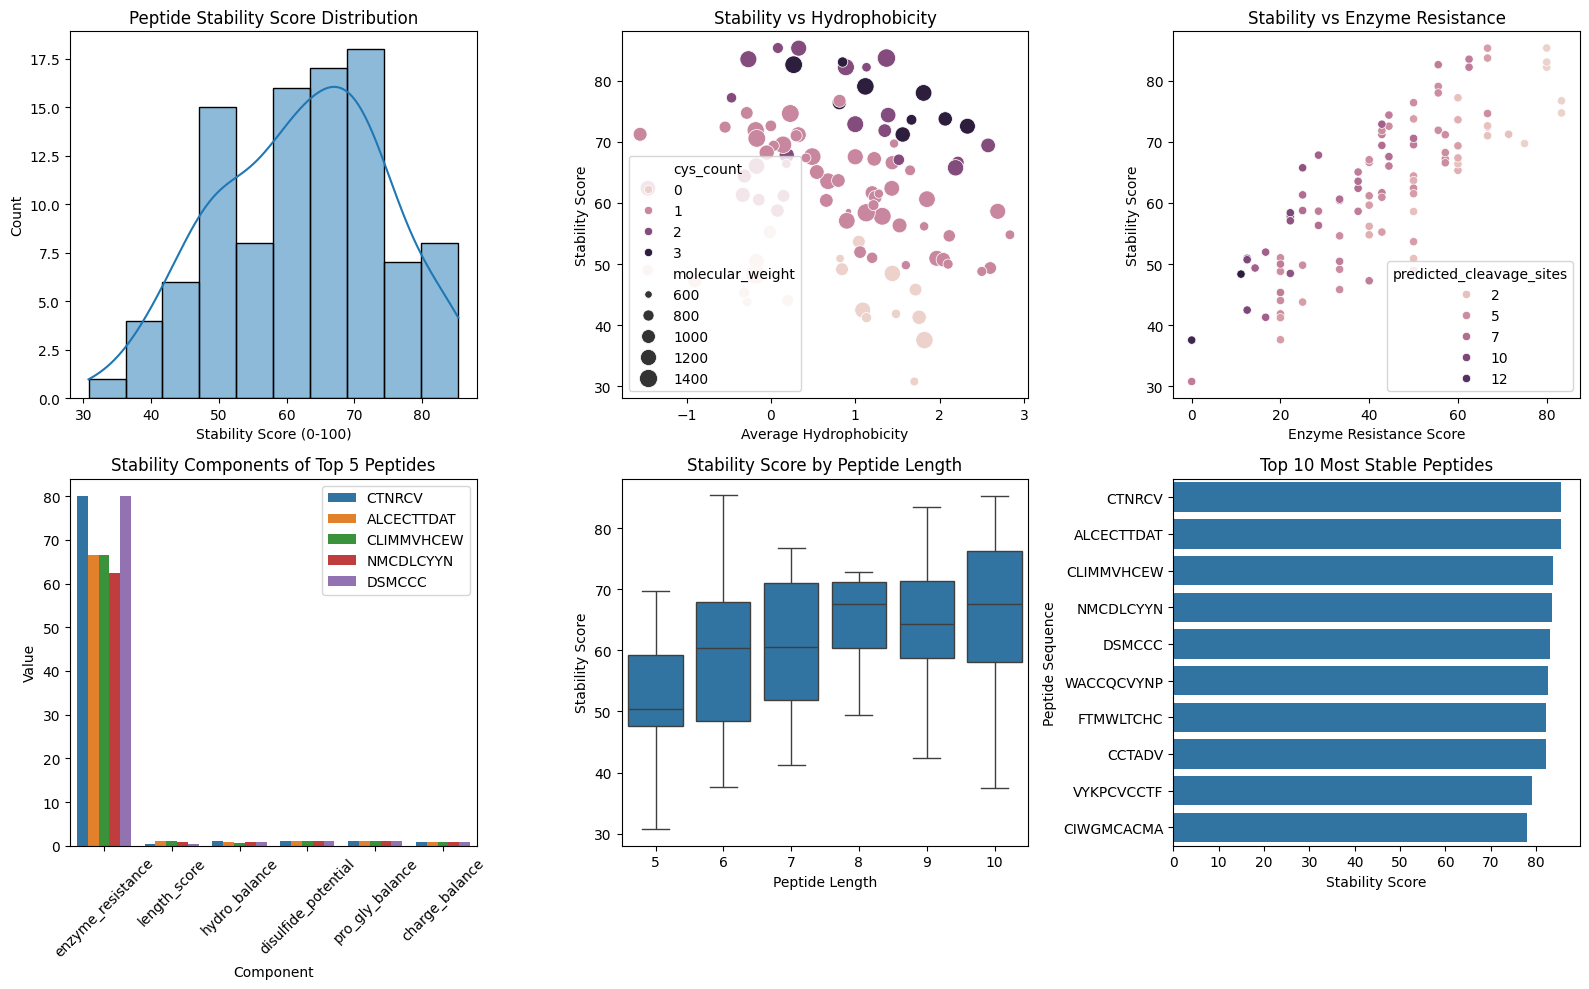


=== 안정성 상위 5개 펩타이드 ===
1. 'CTNRCV': 안정성 점수 85.4/100
   분자량: 784.9, 효소 저항성: 80.0
   시스테인 수: 2, 예상 절단 사이트: 1

2. 'ALCECTTDAT': 안정성 점수 85.3/100
   분자량: 1189.3, 효소 저항성: 66.7
   시스테인 수: 2, 예상 절단 사이트: 4

3. 'CLIMMVHCEW': 안정성 점수 83.7/100
   분자량: 1426.8, 효소 저항성: 66.7
   시스테인 수: 2, 예상 절단 사이트: 4

4. 'NMCDLCYYN': 안정성 점수 83.5/100
   분자량: 1282.4, 효소 저항성: 62.5
   시스테인 수: 2, 예상 절단 사이트: 6

5. 'DSMCCC': 안정성 점수 83.1/100
   분자량: 750.9, 효소 저항성: 80.0
   시스테인 수: 3, 예상 절단 사이트: 1

펩타이드 안정성 분석 완료!


In [ ]:
# 펩타이드 안정성 예측 모델 (수정된 버전)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

# 아미노산 물성 정의
aa_properties = {
    'A': {'hydrophobicity': 1.8, 'weight': 89.09, 'charge': 0, 'bulkiness': 0.52, 'flexibility': 0.36, 'enzyme_sensitivity': 0.3},
    'C': {'hydrophobicity': 2.5, 'weight': 121.16, 'charge': 0, 'bulkiness': 0.62, 'flexibility': 0.41, 'enzyme_sensitivity': 0.5},
    'D': {'hydrophobicity': -3.5, 'weight': 133.10, 'charge': -1, 'bulkiness': 0.57, 'flexibility': 0.51, 'enzyme_sensitivity': 0.6},
    'E': {'hydrophobicity': -3.5, 'weight': 147.13, 'charge': -1, 'bulkiness': 0.68, 'flexibility': 0.64, 'enzyme_sensitivity': 0.6},
    'F': {'hydrophobicity': 2.8, 'weight': 165.19, 'charge': 0, 'bulkiness': 0.88, 'flexibility': 0.31, 'enzyme_sensitivity': 0.7},
    'G': {'hydrophobicity': -0.4, 'weight': 75.07, 'charge': 0, 'bulkiness': 0.36, 'flexibility': 0.54, 'enzyme_sensitivity': 0.3},
    'H': {'hydrophobicity': -3.2, 'weight': 155.16, 'charge': 0.5, 'bulkiness': 0.66, 'flexibility': 0.32, 'enzyme_sensitivity': 0.4},
    'I': {'hydrophobicity': 4.5, 'weight': 131.17, 'charge': 0, 'bulkiness': 0.73, 'flexibility': 0.46, 'enzyme_sensitivity': 0.5},
    'K': {'hydrophobicity': -3.9, 'weight': 146.19, 'charge': 1, 'bulkiness': 0.71, 'flexibility': 0.47, 'enzyme_sensitivity': 0.8},
    'L': {'hydrophobicity': 3.8, 'weight': 131.17, 'charge': 0, 'bulkiness': 0.74, 'flexibility': 0.40, 'enzyme_sensitivity': 0.5},
    'M': {'hydrophobicity': 1.9, 'weight': 149.21, 'charge': 0, 'bulkiness': 0.78, 'flexibility': 0.30, 'enzyme_sensitivity': 0.4},
    'N': {'hydrophobicity': -3.5, 'weight': 132.12, 'charge': 0, 'bulkiness': 0.63, 'flexibility': 0.46, 'enzyme_sensitivity': 0.4},
    'P': {'hydrophobicity': -1.6, 'weight': 115.13, 'charge': 0, 'bulkiness': 0.59, 'flexibility': 0.18, 'enzyme_sensitivity': 0.2},
    'Q': {'hydrophobicity': -3.5, 'weight': 146.15, 'charge': 0, 'bulkiness': 0.68, 'flexibility': 0.49, 'enzyme_sensitivity': 0.4},
    'R': {'hydrophobicity': -4.5, 'weight': 174.20, 'charge': 1, 'bulkiness': 0.85, 'flexibility': 0.47, 'enzyme_sensitivity': 0.8},
    'S': {'hydrophobicity': -0.8, 'weight': 105.09, 'charge': 0, 'bulkiness': 0.53, 'flexibility': 0.51, 'enzyme_sensitivity': 0.4},
    'T': {'hydrophobicity': -0.7, 'weight': 119.12, 'charge': 0, 'bulkiness': 0.60, 'flexibility': 0.44, 'enzyme_sensitivity': 0.4},
    'V': {'hydrophobicity': 4.2, 'weight': 117.15, 'charge': 0, 'bulkiness': 0.66, 'flexibility': 0.39, 'enzyme_sensitivity': 0.4},
    'W': {'hydrophobicity': -0.9, 'weight': 204.23, 'charge': 0, 'bulkiness': 0.98, 'flexibility': 0.31, 'enzyme_sensitivity': 0.6},
    'Y': {'hydrophobicity': -1.3, 'weight': 181.19, 'charge': 0, 'bulkiness': 0.88, 'flexibility': 0.42, 'enzyme_sensitivity': 0.7}
}

# 효소 절단 사이트 데이터
enzyme_cleavage_sites = {
    'pepsin': [(aa, True) for aa in 'FYWL'], # 페닐알라닌, 티로신, 트립토판, 류신 C-말단 절단
    'trypsin': [(aa, True) for aa in 'KR'], # 리신, 아르기닌 C-말단 절단
    'chymotrypsin': [(aa, True) for aa in 'FYW'], # 페닐알라닌, 티로신, 트립토판 C-말단 절단
    'elastase': [(aa, True) for aa in 'AVLIGS'], # 알라닌, 발린, 류신, 이소류신, 글리신, 세린 C-말단 절단
}

# 효소 절단 사이트에 대한 예측 함수
def predict_enzyme_cleavage(sequence, enzyme='all'):
    """
    주어진 펩타이드 시퀀스에서 효소 절단 사이트 예측

    Args:
        sequence: 펩타이드 시퀀스
        enzyme: 'pepsin', 'trypsin', 'chymotrypsin', 'elastase', 또는 'all'

    Returns:
        cleavage_sites: 예상 절단 위치 리스트
        vulnerability_score: 취약성 점수 (0-1, 높을수록 더 취약)
    """
    cleavage_sites = []

    # 모든 효소에 대해 처리
    if enzyme == 'all':
        enzymes = enzyme_cleavage_sites.keys()
    else:
        enzymes = [enzyme]

    for enz in enzymes:
        sites = enzyme_cleavage_sites[enz]
        for i in range(len(sequence) - 1):
            curr_aa = sequence[i]
            for aa, is_c_term in sites:
                if curr_aa == aa:
                    cleavage_sites.append((i, enz))

    # 취약성 점수 계산: 시퀀스 길이 대비 절단 사이트 수
    total_sites = len(set(pos for pos, _ in cleavage_sites))
    vulnerability_score = total_sites / max(1, len(sequence) - 1)

    return cleavage_sites, vulnerability_score

# 구조적 특성 계산
def calculate_structural_properties(sequence):
    """
    펩타이드 시퀀스의 구조적 특성 계산

    Args:
        sequence: 펩타이드 시퀀스

    Returns:
        properties: 구조적 특성 딕셔너리
    """
    props = {}

    # 기본 물성 계산
    hydrophobicity = [aa_properties.get(aa, {'hydrophobicity': 0})['hydrophobicity'] for aa in sequence]
    props['avg_hydrophobicity'] = sum(hydrophobicity) / len(sequence) if sequence else 0

    weights = [aa_properties.get(aa, {'weight': 0})['weight'] for aa in sequence]
    props['molecular_weight'] = sum(weights)

    charges = [aa_properties.get(aa, {'charge': 0})['charge'] for aa in sequence]
    props['net_charge'] = sum(charges)

    # 소수성 아미노산 비율
    hydrophobic_aas = ['A', 'F', 'I', 'L', 'M', 'V', 'W']
    props['hydrophobic_ratio'] = sum(sequence.count(aa) for aa in hydrophobic_aas) / len(sequence) if sequence else 0

    # 시스테인 수 (이황화 결합 가능성)
    props['cys_count'] = sequence.count('C')

    # 유연성 지수
    flexibility = [aa_properties.get(aa, {'flexibility': 0.5})['flexibility'] for aa in sequence]
    props['avg_flexibility'] = sum(flexibility) / len(sequence) if sequence else 0

    # 특수 아미노산 특성
    props['proline_count'] = sequence.count('P')  # 구조 안정화
    props['glycine_count'] = sequence.count('G')  # 유연성 증가

    # 시퀀스 길이
    props['length'] = len(sequence)

    return props

# 안정성 예측 모델
def predict_stability(sequence):
    """
    펩타이드 시퀀스의 안정성 통합 예측

    Args:
        sequence: 펩타이드 시퀀스

    Returns:
        stability_score: 안정성 점수 (0-100, 높을수록 더 안정적)
        properties: 다양한 안정성 관련 특성들
    """
    # 특성 계산
    structural_props = calculate_structural_properties(sequence)
    cleavage_sites, enzyme_vulnerability = predict_enzyme_cleavage(sequence)

    # 시퀀스 길이 점수 (적절한 길이가 안정성에 유리)
    length = structural_props['length']
    length_score = max(0, min(1, (length - 3) / 7))  # 약 5-10 아미노산이 최적
    structural_props['length_score'] = length_score

    # 소수성 균형 점수 (너무 높거나 낮으면 감점)
    hydro_balance = 1 - abs(structural_props['avg_hydrophobicity']) / 5
    structural_props['hydro_balance'] = hydro_balance

    # 이황화 결합 점수
    disulfide_potential = min(1, structural_props['cys_count'] / 2)
    structural_props['disulfide_potential'] = disulfide_potential

    # 구조 안정성 점수 (프롤린, 글리신 균형)
    pro_gly_balance = max(0, 1 - abs(structural_props['proline_count'] - structural_props['glycine_count']) / length)
    structural_props['pro_gly_balance'] = pro_gly_balance

    # 효소 저항성 점수 (1 - 취약성)
    enzyme_resistance = 1 - enzyme_vulnerability
    structural_props['enzyme_resistance'] = enzyme_resistance * 100

    # 전하 균형 점수 (중성에 가까울수록 높음)
    charge_balance = 1 - abs(structural_props['net_charge']) / length
    structural_props['charge_balance'] = charge_balance

    # 가중치 적용한 통합 점수 계산
    weights = {
        'enzyme_resistance': 0.35,
        'length_score': 0.10,
        'hydro_balance': 0.15,
        'disulfide_potential': 0.20,
        'pro_gly_balance': 0.10,
        'charge_balance': 0.10
    }

    # 최종 안정성 점수 (0-100 스케일)
    stability_score = (
        enzyme_resistance * weights['enzyme_resistance'] +
        length_score * weights['length_score'] +
        hydro_balance * weights['hydro_balance'] +
        disulfide_potential * weights['disulfide_potential'] +
        pro_gly_balance * weights['pro_gly_balance'] +
        charge_balance * weights['charge_balance']
    ) * 100

    # 반환 데이터 구성
    results = {
        'sequence': sequence,
        'stability_score': stability_score,
        'predicted_cleavage_sites': len(cleavage_sites)
    }

    # 구조적 특성 추가
    results.update(structural_props)

    return results

# 펩타이드 리스트 안정성 평가
def evaluate_peptides_stability(peptides_df, sequence_col='sequence'):
    """
    펩타이드 데이터프레임의 안정성 평가

    Args:
        peptides_df: 펩타이드 정보가 있는 데이터프레임
        sequence_col: 시퀀스 열 이름

    Returns:
        평가 결과가 추가된 데이터프레임
    """
    results = []

    for i, row in peptides_df.iterrows():
        sequence = row[sequence_col]

        # 문자열 타입 확인 및 변환
        if not isinstance(sequence, str):
            print(f"경고: 행 {i}의 시퀀스가 문자열이 아닙니다. 변환을 시도합니다.")
            try:
                sequence = str(sequence)
            except:
                print(f"  변환 실패, 이 행은 건너뜁니다.")
                continue

        # 빈 문자열 확인
        if not sequence:
            print(f"경고: 행 {i}의 시퀀스가 비어 있습니다. 이 행은 건너뜁니다.")
            continue

        # 안정성 평가
        stability_results = predict_stability(sequence)

        # 원본 행 데이터와 결합
        combined_results = {**row.to_dict(), **stability_results}
        results.append(combined_results)

    return pd.DataFrame(results)

# 안정성 결과 시각화
def visualize_stability_results(results_df, output_file='peptide_stability_analysis.png'):
    """
    안정성 평가 결과 시각화

    Args:
        results_df: 안정성 평가 결과 데이터프레임
        output_file: 출력 이미지 파일 경로
    """
    plt.figure(figsize=(16, 10))

    # 1. 안정성 점수 분포
    plt.subplot(2, 3, 1)
    sns.histplot(results_df['stability_score'], bins=10, kde=True)
    plt.title('Peptide Stability Score Distribution')
    plt.xlabel('Stability Score (0-100)')
    plt.ylabel('Count')

    # 2. 안정성 vs 소수성
    plt.subplot(2, 3, 2)
    sns.scatterplot(x='avg_hydrophobicity', y='stability_score', data=results_df, hue='cys_count', size='molecular_weight', sizes=(20, 200))
    plt.title('Stability vs Hydrophobicity')
    plt.xlabel('Average Hydrophobicity')
    plt.ylabel('Stability Score')

    # 3. 효소 저항성 vs 안정성
    plt.subplot(2, 3, 3)
    sns.scatterplot(x='enzyme_resistance', y='stability_score', data=results_df, hue='predicted_cleavage_sites')
    plt.title('Stability vs Enzyme Resistance')
    plt.xlabel('Enzyme Resistance Score')
    plt.ylabel('Stability Score')

    # 4. 안정성 구성 요소 (막대 그래프로 대체)
    plt.subplot(2, 3, 4)

    # 상위 5개 펩타이드에 대한 안정성 구성 요소
    top_peptides = results_df.sort_values('stability_score', ascending=False).head(5)
    components = ['enzyme_resistance', 'length_score', 'hydro_balance',
                 'disulfide_potential', 'pro_gly_balance', 'charge_balance']

    # 막대 그래프로 표시
    component_df = pd.DataFrame()
    for i, row in enumerate(top_peptides.iterrows()):
        _, peptide = row
        peptide_data = {
            'Peptide': peptide['sequence'],
            'Component': components,
            'Value': [peptide[comp] for comp in components]
        }
        component_df = pd.concat([component_df, pd.DataFrame(peptide_data)])

    sns.barplot(x='Component', y='Value', hue='Peptide', data=component_df)
    plt.title('Stability Components of Top 5 Peptides')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')

    # 5. 시퀀스 길이 vs 안정성
    plt.subplot(2, 3, 5)
    sns.boxplot(x='length', y='stability_score', data=results_df)
    plt.title('Stability Score by Peptide Length')
    plt.xlabel('Peptide Length')
    plt.ylabel('Stability Score')

    # 6. 최상위 안정성 펩타이드
    plt.subplot(2, 3, 6)
    top10 = results_df.sort_values('stability_score', ascending=False).head(10)
    sns.barplot(x='stability_score', y='sequence', data=top10)
    plt.title('Top 10 Most Stable Peptides')
    plt.xlabel('Stability Score')
    plt.ylabel('Peptide Sequence')

    plt.tight_layout()
    plt.savefig(output_file)
    print(f"시각화가 '{output_file}'에 저장되었습니다.")
    plt.show()

    return top10

# 메인 실행 함수
def main():
    """
    펩타이드 안정성 예측 및 평가 실행
    """
    print("펩타이드 안정성 예측 도구 실행 중...")

    # 생성된 펩타이드 파일 확인
    input_file = 'generated_peptides.csv'
    output_file = 'peptides_with_stability.csv'
    visualization_file = 'peptide_stability_analysis.png'

    if not os.path.exists(input_file):
        print(f"입력 파일 '{input_file}'을 찾을 수 없습니다.")

        # 샘플 데이터 생성
        print("샘플 펩타이드 데이터 생성 중...")
        sample_peptides = [
            {'sequence': 'CIIAMA', 'temperature': 0.7},
            {'sequence': 'ALCAAIFA', 'temperature': 0.7},
            {'sequence': 'IFSCVA', 'temperature': 1.0},
            {'sequence': 'CLLVAQ', 'temperature': 1.0},
            {'sequence': 'CAFATW', 'temperature': 1.0},
            {'sequence': 'GRCFML', 'temperature': 0.8},
            {'sequence': 'MVCPLD', 'temperature': 0.9},
            {'sequence': 'LVTCGI', 'temperature': 1.1},
            {'sequence': 'KVWCSF', 'temperature': 1.2},
            {'sequence': 'FACLPM', 'temperature': 0.7}
        ]
        peptides_df = pd.DataFrame(sample_peptides)
        print(f"샘플 데이터 {len(peptides_df)}개 생성됨")
    else:
        # 실제 데이터 로드
        print(f"'{input_file}'에서 펩타이드 데이터 로드 중...")
        peptides_df = pd.read_csv(input_file)
        print(f"{len(peptides_df)}개 펩타이드 로드됨")

    # 안정성 평가 수행
    print("펩타이드 안정성 평가 중...")
    results_df = evaluate_peptides_stability(peptides_df)

    # 결과 저장
    results_df.to_csv(output_file, index=False)
    print(f"안정성 평가 결과 '{output_file}'에 저장됨")

    # 결과 시각화
    print("결과 시각화 중...")
    top_peptides = visualize_stability_results(results_df, visualization_file)

    # 상위 안정성 펩타이드 출력
    print("\n=== 안정성 상위 5개 펩타이드 ===")
    for i, (_, row) in enumerate(top_peptides.head(5).iterrows()):
        print(f"{i+1}. '{row['sequence']}': 안정성 점수 {row['stability_score']:.1f}/100")
        print(f"   분자량: {row['molecular_weight']:.1f}, 효소 저항성: {row['enzyme_resistance']:.1f}")
        print(f"   시스테인 수: {row['cys_count']}, 예상 절단 사이트: {row['predicted_cleavage_sites']}")
        print()

    print("펩타이드 안정성 분석 완료!")

# 스크립트 실행
if __name__ == "__main__":
    main()

# 7 최적 후보 선정

# 최적 후보 선정


입력 파일: generated_peptides.csv
평가 결과 파일: evaluated_peptides.csv
최적 후보 파일: optimal_candidates.csv
시각화 파일: optimal_candidates_plot.png
100개 펩타이드를 generated_peptides.csv에서 불러왔습니다.
평가 결과가 evaluated_peptides.csv에 저장되었습니다.

평가 요약:
총 펩타이드 수: 100
경구 활성 예측 펩타이드: 53개
평균 분자량: 1002.40 Da
평균 소수성: 0.89

경구 활성 예측 펩타이드: 53개
상위 5개 후보가 optimal_candidates.csv에 저장되었습니다.
시각화가 optimal_candidates_plot.png에 저장되었습니다.


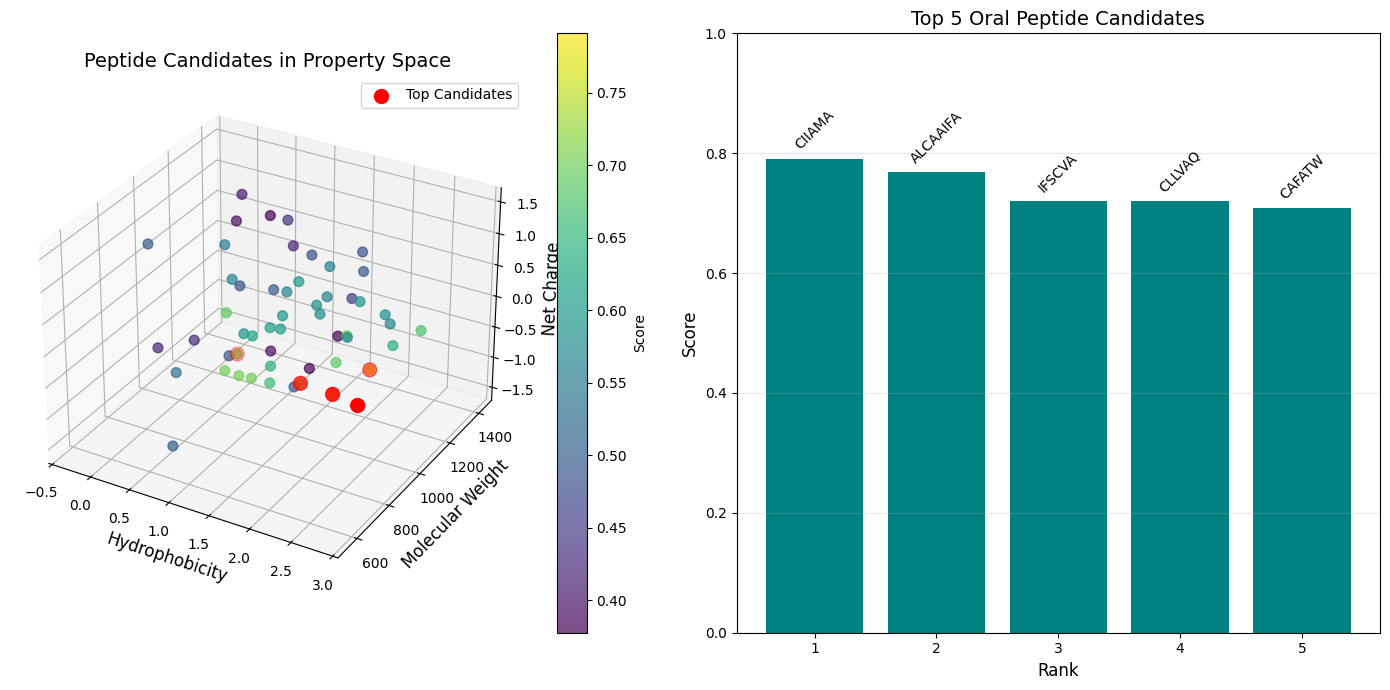


최적 경구 펩타이드 후보 상세 정보:
1. 시퀀스: CIIAMA
   분자량: 710.89 Da
   소수성: 2.83
   순 전하: 0.0
   소수성 비율: 0.83
   점수: 0.7912

2. 시퀀스: ALCAAIFA
   분자량: 905.05 Da
   소수성: 2.60
   순 전하: 0.0
   소수성 비율: 0.88
   점수: 0.7690

3. 시퀀스: IFSCVA
   분자량: 728.85 Da
   소수성: 2.50
   순 전하: 0.0
   소수성 비율: 0.67
   점수: 0.7209

4. 시퀀스: CLLVAQ
   분자량: 735.89 Da
   소수성: 2.10
   순 전하: 0.0
   소수성 비율: 0.67
   점수: 0.7195

5. 시퀀스: CAFATW
   분자량: 787.88 Da
   소수성: 1.22
   순 전하: 0.0
   소수성 비율: 0.67
   점수: 0.7091



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 펩타이드 물성 계산 함수
def calculate_properties(peptide):
    """Calculate peptide properties"""
    # Check if peptide is a string
    if not isinstance(peptide, str):
        print(f"Warning: Invalid peptide value: {peptide} (type: {type(peptide)})")
        # Convert to string if possible, otherwise use empty string
        try:
            peptide = str(peptide)
        except:
            return {
                'molecular_weight': 0,
                'hydrophobicity': 0,
                'net_charge': 0,
                'hydrophobic_ratio': 0,
                'cys_count': 0,
                'predicted_oral': 0
            }

    # Amino acid properties (hydrophobicity, molecular weight, charge)
    aa_properties = {
        'A': {'hydrophobicity': 1.8, 'weight': 89.09, 'charge': 0},
        'C': {'hydrophobicity': 2.5, 'weight': 121.16, 'charge': 0},
        'D': {'hydrophobicity': -3.5, 'weight': 133.10, 'charge': -1},
        'E': {'hydrophobicity': -3.5, 'weight': 147.13, 'charge': -1},
        'F': {'hydrophobicity': 2.8, 'weight': 165.19, 'charge': 0},
        'G': {'hydrophobicity': -0.4, 'weight': 75.07, 'charge': 0},
        'H': {'hydrophobicity': -3.2, 'weight': 155.16, 'charge': 0.5},
        'I': {'hydrophobicity': 4.5, 'weight': 131.17, 'charge': 0},
        'K': {'hydrophobicity': -3.9, 'weight': 146.19, 'charge': 1},
        'L': {'hydrophobicity': 3.8, 'weight': 131.17, 'charge': 0},
        'M': {'hydrophobicity': 1.9, 'weight': 149.21, 'charge': 0},
        'N': {'hydrophobicity': -3.5, 'weight': 132.12, 'charge': 0},
        'P': {'hydrophobicity': -1.6, 'weight': 115.13, 'charge': 0},
        'Q': {'hydrophobicity': -3.5, 'weight': 146.15, 'charge': 0},
        'R': {'hydrophobicity': -4.5, 'weight': 174.20, 'charge': 1},
        'S': {'hydrophobicity': -0.8, 'weight': 105.09, 'charge': 0},
        'T': {'hydrophobicity': -0.7, 'weight': 119.12, 'charge': 0},
        'V': {'hydrophobicity': 4.2, 'weight': 117.15, 'charge': 0},
        'W': {'hydrophobicity': -0.9, 'weight': 204.23, 'charge': 0},
        'Y': {'hydrophobicity': -1.3, 'weight': 181.19, 'charge': 0}
    }

    # Calculate properties
    props = {}

    # Molecular weight
    props['molecular_weight'] = sum(aa_properties.get(aa, {'weight': 0})['weight'] for aa in peptide)

    # Hydrophobicity
    hydrophobicity = [aa_properties.get(aa, {'hydrophobicity': 0})['hydrophobicity'] for aa in peptide]
    props['hydrophobicity'] = sum(hydrophobicity) / len(peptide) if peptide else 0

    # Net charge
    props['net_charge'] = sum(aa_properties.get(aa, {'charge': 0})['charge'] for aa in peptide)

    # Hydrophobic amino acid ratio
    hydrophobic_aas = ['A', 'F', 'I', 'L', 'M', 'V', 'W']
    props['hydrophobic_ratio'] = sum(peptide.count(aa) for aa in hydrophobic_aas) / len(peptide) if peptide else 0

    # Cys count (disulfide bond potential)
    props['cys_count'] = peptide.count('C')

    # Predicted oral bioavailability (simple rule-based)
    if (props['hydrophobic_ratio'] >= 0.4 and props['cys_count'] > 0 and len(peptide) < 12):
        props['predicted_oral'] = 1
    else:
        props['predicted_oral'] = 0

    return props

# 펩타이드 파일 평가 함수 - Colab에서 직접 실행 가능
def evaluate_peptide_file(input_file="generated_peptides.csv",
                          output_file=None,
                          candidates_file=None,
                          plot_file=None):
    """
    CSV 파일에서 펩타이드를 평가하고 최적 후보 선정
    """
    # 기본 파일명 설정
    if output_file is None:
        output_file = "evaluated_peptides.csv"
    if candidates_file is None:
        candidates_file = "optimal_candidates.csv"
    if plot_file is None:
        plot_file = "optimal_candidates_plot.png"

    print(f"입력 파일: {input_file}")
    print(f"평가 결과 파일: {output_file}")
    print(f"최적 후보 파일: {candidates_file}")
    print(f"시각화 파일: {plot_file}")

    # 1. 파일에서 펩타이드 불러오기
    try:
        peptide_df = pd.read_csv(input_file)
        print(f"{len(peptide_df)}개 펩타이드를 {input_file}에서 불러왔습니다.")

        # 필수 열 확인
        if 'sequence' not in peptide_df.columns:
            # 열 이름 탐색 시도
            possible_columns = ['peptide', 'sequence', 'peptide_sequence']
            for col in possible_columns:
                if col in peptide_df.columns:
                    peptide_df['sequence'] = peptide_df[col]
                    print(f"'{col}' 열을 'sequence' 열로 사용합니다.")
                    break
            else:
                # 열을 찾지 못했을 경우, 첫 번째 문자열 열을 사용
                for col in peptide_df.columns:
                    if peptide_df[col].dtype == 'object':  # 문자열 열
                        peptide_df['sequence'] = peptide_df[col]
                        print(f"'{col}' 열을 'sequence' 열로 사용합니다.")
                        break
                else:
                    raise ValueError("입력 파일에 적합한 시퀀스 열이 없습니다.")

    except Exception as e:
        print(f"파일 불러오기 오류: {e}")
        return None

    # 2. 펩타이드 평가
    properties_list = []
    for i, row in peptide_df.iterrows():
        peptide = row['sequence']

        # 데이터 타입 검증
        if not isinstance(peptide, str):
            print(f"경고: 행 {i+1}의 시퀀스 값이 문자열이 아닙니다: {peptide} (타입: {type(peptide).__name__})")
            try:
                peptide = str(peptide)
                print(f"  -> 문자열로 변환했습니다: '{peptide}'")
            except:
                print(f"  -> 변환 실패, 이 행은 건너뜁니다.")
                continue

        # 빈 문자열 검사
        if not peptide:
            print(f"경고: 행 {i+1}의 시퀀스가 비어 있습니다. 이 행은 건너뜁니다.")
            continue

        # 펩타이드 물성 계산
        try:
            props = calculate_properties(peptide)
            props['sequence'] = peptide

            # 추가 열 복사
            for col in peptide_df.columns:
                if col != 'sequence':
                    props[col] = row[col]

            properties_list.append(props)
        except Exception as e:
            print(f"오류: 행 {i+1}의 펩타이드 '{peptide}' 물성 계산 중 오류 발생: {e}")
            continue

    # 결과가 없는 경우 처리
    if not properties_list:
        print("오류: 처리할 수 있는 유효한 펩타이드가 없습니다.")
        return None

    # DataFrame으로 변환
    results_df = pd.DataFrame(properties_list)

    # 3. 평가 결과 저장
    results_df.to_csv(output_file, index=False)
    print(f"평가 결과가 {output_file}에 저장되었습니다.")

    # 4. 요약 정보 출력
    print(f"\n평가 요약:")
    print(f"총 펩타이드 수: {len(results_df)}")
    print(f"경구 활성 예측 펩타이드: {results_df['predicted_oral'].sum()}개")
    print(f"평균 분자량: {results_df['molecular_weight'].mean():.2f} Da")
    print(f"평균 소수성: {results_df['hydrophobicity'].mean():.2f}")

    # 5. 최적 후보 선정
    # 경구 활성 있는 펩타이드만 선택
    oral_candidates = results_df[results_df['predicted_oral'] == 1].copy()
    print(f"\n경구 활성 예측 펩타이드: {len(oral_candidates)}개")

    if len(oral_candidates) > 0:
        # 점수 계산
        oral_candidates['score'] = (
            oral_candidates['hydrophobic_ratio'] * 0.4 +
            (1 / (1 + abs(oral_candidates['net_charge']))) * 0.3 +
            (1 - (oral_candidates['molecular_weight'] / 1500)) * 0.3
        )

        # 상위 5개 후보 선정
        n_candidates = min(5, len(oral_candidates))
        top_candidates = oral_candidates.sort_values('score', ascending=False).head(n_candidates)

        # 최적 후보 저장
        top_candidates.to_csv(candidates_file, index=False)
        print(f"상위 {n_candidates}개 후보가 {candidates_file}에 저장되었습니다.")

        # 시각화
        plt.figure(figsize=(14, 7))

        # 3D 산점도
        ax = plt.subplot(121, projection='3d')
        scatter = ax.scatter(
            oral_candidates['hydrophobicity'],
            oral_candidates['molecular_weight'],
            oral_candidates['net_charge'],
            c=oral_candidates['score'],
            cmap='viridis',
            alpha=0.7,
            s=50
        )

        # 상위 후보 강조
        ax.scatter(
            top_candidates['hydrophobicity'],
            top_candidates['molecular_weight'],
            top_candidates['net_charge'],
            color='red',
            s=100,
            label='Top Candidates'
        )

        ax.set_xlabel('Hydrophobicity', fontsize=12)
        ax.set_ylabel('Molecular Weight', fontsize=12)
        ax.set_zlabel('Net Charge', fontsize=12)
        ax.set_title('Peptide Candidates in Property Space', fontsize=14)
        plt.colorbar(scatter, label='Score')
        ax.legend()

        # 점수 그래프
        ax2 = plt.subplot(122)
        bars = ax2.bar(
            range(1, n_candidates + 1),
            top_candidates['score'].values,
            color='teal'
        )

        # 막대 위에 시퀀스 표시
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.01,
                f'{top_candidates["sequence"].values[i]}',
                ha='center',
                va='bottom',
                rotation=45,
                fontsize=10
            )

        ax2.set_xlabel('Rank', fontsize=12)
        ax2.set_ylabel('Score', fontsize=12)
        ax2.set_title(f'Top {n_candidates} Oral Peptide Candidates', fontsize=14)
        ax2.set_ylim(0, 1.0)
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(plot_file)
        print(f"시각화가 {plot_file}에 저장되었습니다.")
        plt.show()

        # 상위 후보 상세 정보 출력
        print("\n최적 경구 펩타이드 후보 상세 정보:")
        for i, (_, row) in enumerate(top_candidates.iterrows()):
            print(f"{i+1}. 시퀀스: {row['sequence']}")
            print(f"   분자량: {row['molecular_weight']:.2f} Da")
            print(f"   소수성: {row['hydrophobicity']:.2f}")
            print(f"   순 전하: {row['net_charge']:.1f}")
            print(f"   소수성 비율: {row['hydrophobic_ratio']:.2f}")
            print(f"   점수: {row['score']:.4f}")
            print()

        return top_candidates
    else:
        print("경구 활성이 예측된 펩타이드가 없습니다.")
        return pd.DataFrame()

# 사용 예시:
top_peptides = evaluate_peptide_file("generated_peptides.csv")

# 보너스~~ 펩타이드 3D 구조

In [ ]:
# @title 최적 펩타이드의 3차원 구조 시각화 (필요한 패키지 설치 포함)

# 먼저 필요한 패키지 설치 - 별도 실행 (설치에 시간이 걸릴 수 있습니다)
!pip install py3Dmol rdkit-pypi -q

# 설치 후 코드 실행
import pandas as pd
import numpy as np
import time
import os
from IPython.display import display
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# 패키지 임포트
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem

# 펩타이드 구조 생성 함수
def generate_peptide_3d_structure(sequence, output_pdb=None):
    """
    펩타이드 시퀀스로부터 3D 구조를 생성하고 PDB 파일로 저장

    Args:
        sequence: 아미노산 시퀀스 (1글자 코드, 예: 'ACGF')
        output_pdb: 출력 PDB 파일명 (기본값: None)

    Returns:
        RDKit 분자 객체
    """
    # 3글자 아미노산 코드로 변환
    aa_dict = {
        'A': 'ALA', 'C': 'CYS', 'D': 'ASP', 'E': 'GLU',
        'F': 'PHE', 'G': 'GLY', 'H': 'HIS', 'I': 'ILE',
        'K': 'LYS', 'L': 'LEU', 'M': 'MET', 'N': 'ASN',
        'P': 'PRO', 'Q': 'GLN', 'R': 'ARG', 'S': 'SER',
        'T': 'THR', 'V': 'VAL', 'W': 'TRP', 'Y': 'TYR'
    }

    # 펩타이드 생성
    mol = Chem.MolFromSequence(''.join([aa_dict.get(aa, 'GLY') for aa in sequence]))

    if mol is None:
        print(f"경고: 시퀀스 '{sequence}'에서 분자 생성 실패. 기본 구조 사용.")
        # 기본 분자 생성 (GLY 반복)
        mol = Chem.MolFromSequence(''.join(['GLY' for _ in sequence]))

    # 수소 추가 및 3D 구조 생성
    mol = Chem.AddHs(mol)

    # 구조 최적화 (최대 100회 시도)
    try:
        AllChem.EmbedMolecule(mol, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=500)
    except:
        print(f"경고: 시퀀스 '{sequence}'의 3D 구조 최적화 실패.")
        try:
            # 다른 방법으로 시도
            AllChem.EmbedMolecule(mol, useRandomCoords=True, randomSeed=42)
            AllChem.UFFOptimizeMolecule(mol, maxIters=200)
        except:
            print(f"경고: 대체 방법으로도 최적화 실패.")

    # PDB 파일로 저장
    if output_pdb:
        pdb_writer = Chem.PDBWriter(output_pdb)
        pdb_writer.write(mol)
        pdb_writer.close()
        print(f"PDB 파일이 '{output_pdb}'에 저장되었습니다.")

    return mol

# 3D 구조를 시각화하는 함수
def visualize_peptide_3d(mol, sequence, width=500, height=400):
    """
    RDKit 분자 객체의 3D 구조를 시각화

    Args:
        mol: RDKit 분자 객체
        sequence: 펩타이드 시퀀스
        width: 시각화 너비
        height: 시각화 높이
    """
    # 시각화를 위한 3Dmol 객체 생성
    view = py3Dmol.view(width=width, height=height)

    # 분자 추가
    mb = Chem.MolToMolBlock(mol)
    view.addModel(mb, 'mol')

    # 스타일 설정
    view.setStyle({'stick': {'radius': 0.2, 'colorscheme': 'cyanCarbon'}})
    view.addStyle({'atom': 'C'}, {'stick': {'colorscheme': 'greenCarbon'}})
    view.addStyle({'atom': 'N'}, {'stick': {'color': 'blue'}})
    view.addStyle({'atom': 'O'}, {'stick': {'color': 'red'}})
    view.addStyle({'atom': 'S'}, {'stick': {'color': 'yellow'}})

    # 분자 표면 추가
    view.addSurface(py3Dmol.VDW, {'opacity': 0.4, 'colorscheme': 'whiteCarbon'})

    # 카메라 설정 및 줌
    view.zoomTo()

    # 제목
    view.addLabel(f"Peptide: {sequence}", {'position': {'x': 0, 'y': 0, 'z': 0},
                                         'backgroundColor': 'white',
                                         'fontColor': 'black',
                                         'backgroundOpacity': 0.5})

    # 표시
    view.render()

    return view

# 여러 펩타이드 비교 시각화
def visualize_multiple_peptides(peptide_sequences, output_dir='peptide_structures'):
    """
    여러 펩타이드의 3D 구조를 생성하고 시각화

    Args:
        peptide_sequences: 펩타이드 시퀀스 목록
        output_dir: PDB 파일 저장 디렉토리
    """
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 각 펩타이드 처리
    for i, seq in enumerate(peptide_sequences):
        print(f"\n[{i+1}/{len(peptide_sequences)}] 펩타이드 '{seq}' 처리 중...")

        # PDB 파일명
        pdb_file = os.path.join(output_dir, f"peptide_{i+1}_{seq}.pdb")

        # 3D 구조 생성
        try:
            mol = generate_peptide_3d_structure(seq, pdb_file)

            # 시각화
            print(f"펩타이드 '{seq}'의 3D 구조 시각화:")
            view = visualize_peptide_3d(mol, seq)
            display(view)

            # 잠시 대기 (시각화 로딩을 위해)
            time.sleep(1)
        except Exception as e:
            print(f"펩타이드 '{seq}' 처리 중 오류 발생: {e}")

# 메인 실행 코드
try:
    # 최적 펩타이드 후보 데이터 불러오기
    top_candidates = pd.read_csv("optimal_candidates.csv")
    print(f"최적 펩타이드 {len(top_candidates)}개를 불러왔습니다.")

    # 시퀀스 추출
    sequences = top_candidates['sequence'].tolist()

    if sequences:
        print(f"분석할 펩타이드 시퀀스: {sequences}")

        # 3D 구조 생성 및 시각화
        visualize_multiple_peptides(sequences)
    else:
        print("처리할 펩타이드 시퀀스가 없습니다.")

except Exception as e:
    print(f"오류 발생: {e}")
    print("\n샘플 펩타이드로 시각화를 진행합니다.")

    # 샘플 펩타이드 시퀀스
    sample_sequences = ["ACLFMVR", "VLFCAIP", "AFGCILV", "MCKQASV", "VAIPCL"]

    # 3D 구조 생성 및 시각화
    visualize_multiple_peptides(sample_sequences)

최적 펩타이드 5개를 불러왔습니다.
분석할 펩타이드 시퀀스: ['CIIAMA', 'ALCAAIFA', 'IFSCVA', 'CLLVAQ', 'CAFATW']

[1/5] 펩타이드 'CIIAMA' 처리 중...
경고: 시퀀스 'CIIAMA'의 3D 구조 최적화 실패.
PDB 파일이 'peptide_structures/peptide_1_CIIAMA.pdb'에 저장되었습니다.
펩타이드 'CIIAMA'의 3D 구조 시각화:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[2/5] 펩타이드 'ALCAAIFA' 처리 중...
경고: 시퀀스 'ALCAAIFA'에서 분자 생성 실패. 기본 구조 사용.
경고: 시퀀스 'ALCAAIFA'의 3D 구조 최적화 실패.
PDB 파일이 'peptide_structures/peptide_2_ALCAAIFA.pdb'에 저장되었습니다.
펩타이드 'ALCAAIFA'의 3D 구조 시각화:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[3/5] 펩타이드 'IFSCVA' 처리 중...
경고: 시퀀스 'IFSCVA'의 3D 구조 최적화 실패.
PDB 파일이 'peptide_structures/peptide_3_IFSCVA.pdb'에 저장되었습니다.
펩타이드 'IFSCVA'의 3D 구조 시각화:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[4/5] 펩타이드 'CLLVAQ' 처리 중...
경고: 시퀀스 'CLLVAQ'에서 분자 생성 실패. 기본 구조 사용.
경고: 시퀀스 'CLLVAQ'의 3D 구조 최적화 실패.
PDB 파일이 'peptide_structures/peptide_4_CLLVAQ.pdb'에 저장되었습니다.
펩타이드 'CLLVAQ'의 3D 구조 시각화:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[5/5] 펩타이드 'CAFATW' 처리 중...
경고: 시퀀스 'CAFATW'의 3D 구조 최적화 실패.
PDB 파일이 'peptide_structures/peptide_5_CAFATW.pdb'에 저장되었습니다.
펩타이드 'CAFATW'의 3D 구조 시각화:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.